In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

Welcome to this lab session 2 on Time series modeling for air pollution monitoring with a focus on the
calibration of low-cost sensors.

This lab session is based on the data and methods provided in the study by [Ellen M. Considine et al](https://www.sciencedirect.com/science/article/pii/S0269749120365222).

In this notebook we perform exploratory data analysis on our cleaned data from session 1.

In statistics, exploratory data analysis is an approach of analyzing data sets to summarize their main characteristics, often using statistical graphics and other data visualization methods. - [Wikipedia](https://en.wikipedia.org/wiki/Exploratory_data_analysis)

We will be asking ourselves the following questions:
    
- What is the geospatial context of the locations of our sensors (and the data they collect)?
- What is the length of arterial roads with 500 meter radius from each of the monitor locations?
- What are the summary statistics of the airnow and CS PM2.5, and what can we observe from these statistics?
- Using scatter plots and histograms to deepen our understanding of the possible disparities between airnow and CS readings. Here, we want to observe if there is a linear relationship between these readings.
- What happens on weekends? Is there a significant difference?
- Correlation matrix and scatter matrix between variables

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

import geopandas
import contextily as cx

<IPython.core.display.Javascript object>

# Load the training data from disk

The data is stored in a `.csv`file (with column names as keys to access the different time series variables). Pandas dataframes give use the possibility to manilpulate these kinds of files

In [3]:
data_root = "./data/"
training_data_path = data_root + "cleaned_training.csv"
test_data_path = data_root + "cleaned_test.csv"

training_data = pd.read_csv(training_data_path)
test_data = pd.read_csv(test_data_path)

full_data = pd.concat([training_data, test_data], axis=0)

<IPython.core.display.Javascript object>

In [4]:
full_data.dtypes

airnow_sensor     object
longitude        float64
latitude         float64
a_road_500       float64
pm_cs            float64
temp             float64
humidity         float64
pm_airnow        float64
date_time         object
cs_sensor         object
time               int64
month              int64
weekend            int64
sin_time         float64
cos_time         float64
sin_month        float64
cos_month        float64
dtype: object

<IPython.core.display.Javascript object>

In [5]:
full_data.head()

,airnow_sensor,longitude,latitude,a_road_500,pm_cs,temp,humidity,pm_airnow,date_time,cs_sensor,time,month,weekend,sin_time,cos_time,sin_month,cos_month
0,NJH,-104.939925,39.738578,1.995,33.6167,60.038,65.0850,22.10,2018-08-20 01:00:00,NJH,1,8,0,0.220297,0.141451,0.518027,-0.076184
1,NJH,-104.939925,39.738578,1.995,38.2333,58.517,67.1150,27.10,2018-08-20 02:00:00,NJH,2,8,0,0.238054,-0.108947,0.518027,-0.076184
2,NJH,-104.939925,39.738578,1.995,43.3500,57.383,71.1717,28.85,2018-08-20 03:00:00,NJH,3,8,0,0.036945,-0.259179,0.518027,-0.076184
3,NJH,-104.939925,39.738578,1.995,48.7000,56.546,74.7317,34.60,2018-08-20 04:00:00,NJH,4,8,0,-0.198130,-0.171123,0.518027,-0.076184
4,NJH,-104.939925,39.738578,1.995,39.2500,55.682,79.2033,31.50,2018-08-20 05:00:00,NJH,5,8,0,-0.251046,0.074263,0.518027,-0.076184


<IPython.core.display.Javascript object>

Any NaN values?

In [6]:
full_data.isna().sum()

airnow_sensor    0
longitude        0
latitude         0
a_road_500       0
pm_cs            0
temp             0
humidity         0
pm_airnow        0
date_time        0
cs_sensor        0
time             0
month            0
weekend          0
sin_time         0
cos_time         0
sin_month        0
cos_month        0
dtype: int64

<IPython.core.display.Javascript object>

In [7]:
full_data["date_time"] = pd.to_datetime(full_data["date_time"])

<IPython.core.display.Javascript object>

Now, we want to split our dataframe by sensor because we will be using these different sections of our data multiple times in this notebook.

# 1. Plot latitude and langitude of each sensing location with basemap to provide context.

Here we will use a `groupby` function in pandas. It is used to group large amounts of data by descrete values contained in columns of the data.

The `pandas.groupby.nth()` function is used to get the value corresponding the nth row for each group. To get the first value in a group, pass 0 as an argument to the `nth()` method. 

In [8]:
locations = (
    full_data[["airnow_sensor", "longitude", "latitude"]]
    .groupby(by="airnow_sensor")
    .nth(0)
    .reset_index()
)

<IPython.core.display.Javascript object>

In [9]:
locations

,airnow_sensor,longitude,latitude
0,CAMP,-104.987625,39.751184
1,NJH,-104.939925,39.738578
2,i25_denver,-105.015317,39.732146
3,i25_glo,-104.988878,39.785902
4,la_casa,-105.005191,39.779467


<IPython.core.display.Javascript object>

The `contextily` package is used to retrieve web map tiles from a number of sources (OpenStreetMap, Stamen). We can use this package to add basemap to enhance `geopandas.GeoDataFrame`plots.

In [10]:
geo_df = geopandas.GeoDataFrame(
    locations,
    geometry=geopandas.points_from_xy(locations.longitude, locations.latitude),
)

geo_df = geo_df.set_crs("epsg:4326")

<IPython.core.display.Javascript object>

In [11]:
geo_df

,airnow_sensor,longitude,latitude,geometry
0,CAMP,-104.987625,39.751184,POINT (-104.98762 39.75118)
1,NJH,-104.939925,39.738578,POINT (-104.93993 39.73858)
2,i25_denver,-105.015317,39.732146,POINT (-105.01532 39.73215)
3,i25_glo,-104.988878,39.785902,POINT (-104.98888 39.78590)
4,la_casa,-105.005191,39.779467,POINT (-105.00519 39.77947)


<IPython.core.display.Javascript object>

In [12]:
geo_df.dtypes

airnow_sensor      object
longitude         float64
latitude          float64
geometry         geometry
dtype: object

<IPython.core.display.Javascript object>

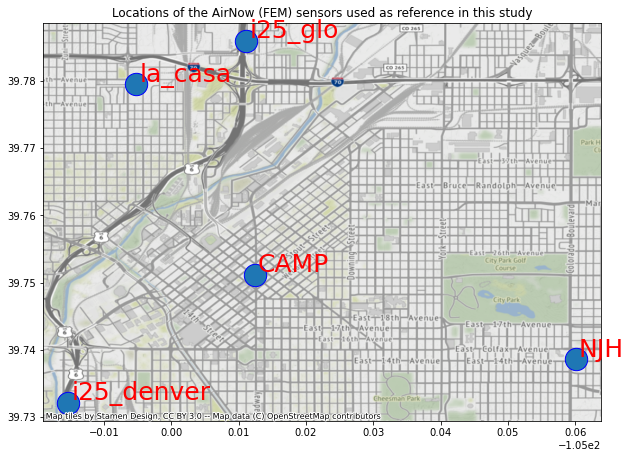

<IPython.core.display.Javascript object>

In [13]:
ax = geo_df.plot(
    figsize=(10, 10),
    alpha=1,
    edgecolor="b",
    legend=True,
    markersize=500,
    legend_kwds={"labels": geo_df["airnow_sensor"]},
)

for x, y, label in zip(geo_df.geometry.x, geo_df.geometry.y, geo_df["airnow_sensor"]):
    ax.annotate(
        label,
        xy=(x, y),
        xytext=(3, 3),
        textcoords="offset points",
        fontsize=25,
        color="r",
    )
plt.title("Locations of the AirNow (FEM) sensors used as reference in this study")
cx.add_basemap(ax, crs=geo_df.crs)

- The National Jewish Hospital (NJH) is farther away from the highway than the rest of the monitor locations. CAMP is also reltively far from large roads. This should have potential impact on how much and the variability of the PM2.5 atmospheric content sensed in these locations.

# 2. Exploring road length variables

Here we want to explore the lengths of arterial (Large) roads within 500m buffer surrounding each monitor location. We do this using a bar plot/chart.

A bar chart or bar graph is a chart or graph that presents categorical data with rectangular bars with heights or lengths proportional to the values that they represent. - [Wikipedia](https://en.wikipedia.org/wiki/Bar_chart)

In [14]:
full_data_roads = (
    full_data.groupby(by="airnow_sensor")
    .nth(0)
    .reset_index()[["airnow_sensor", "a_road_500"]]
)

<IPython.core.display.Javascript object>

In [15]:
full_data_roads

,airnow_sensor,a_road_500
0,CAMP,6.850
1,NJH,1.995
2,i25_denver,2.195
3,i25_glo,1.295
4,la_casa,1.727


<IPython.core.display.Javascript object>

### Exercise 1: Obtain a bar plot of the road length for each monitor location using the given dataframe

Can you observe for 

**Follow up: What can you observe for from the plot?**

**Follow up: What can you observe (differently) for training and test set from the plot?**

Training: NJH, i25_glo, la_casa <br>
Test: CAMP, i25_denver

**Follow up: If you observed anything, how can we verify what you have observed?**

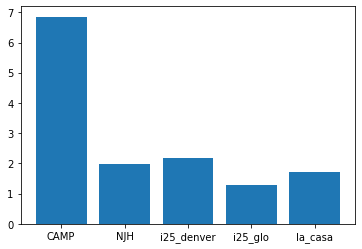

<IPython.core.display.Javascript object>

In [16]:
plt.bar(full_data_roads["airnow_sensor"], full_data_roads["a_road_500"])
plt.show()

# 3. Summary statistics of our data

First, we obtain the summary statistics our "true" data, i.e the data from our monitor sensors (named `pm_airnow`) in our dataframe.

###### Training

In [17]:
training_data.groupby("cs_sensor")[["pm_airnow"]].describe()

pm_airnow                                                   
              count       mean       std  min  25%  50%      75%   max
cs_sensor                                                             
NJH          5271.0   7.688446  6.720115  0.8  3.8  5.8   8.9000  74.2
i25_glo_1    6030.0  11.032040  8.458745  0.2  5.3  8.8  14.1875  72.8
i25_glo_2    5964.0  10.382705  7.003322  0.2  5.3  8.6  13.6000  54.1
i25_glo_3    6113.0  10.983592  8.409551  0.2  5.3  8.8  14.1000  72.8
la_casa      6351.0   8.251268  7.115029  0.2  4.0  6.3  10.1000  76.5

<IPython.core.display.Javascript object>

###### Test

In [18]:
test_data.groupby("cs_sensor")[["pm_airnow"]].describe()

pm_airnow                                              
               count      mean       std  min  25%  50%  75%   max
cs_sensor                                                         
CAMP           737.0  6.307802  3.589595  0.6  3.9  5.5  7.9  27.2
i25_denver    2269.0  7.783010  5.718330  0.5  3.9  6.4  9.9  56.2

<IPython.core.display.Javascript object>

**Observations**

- NJH in training and CAMP in test data show relatively lower median values<br>
- The IQR for both NJH and CAMP are also lower than the rest.


### Summary statistics of the CS (low-cost) sensor data?

Remember, the column named `cs_sensor`provides the CS sensor tag for each data row and column named `pm_cs` contains the CA sensor data

###### Training

In [19]:
training_data.groupby("cs_sensor")[["pm_cs"]].describe()

pm_cs                                                              \
            count       mean        std     min       25%      50%        75%   
cs_sensor                                                                       
NJH        5271.0   7.686516  10.103100  0.0002  1.236950  4.06730   9.815800   
i25_glo_1  6030.0  12.206982  12.716104  0.0013  3.547275  8.11415  16.135200   
i25_glo_2  5964.0   9.139192   9.097960  0.0012  2.709325  6.44350  12.300825   
i25_glo_3  6113.0  10.878979  11.726322  0.0028  3.019500  7.10320  13.997800   
la_casa    6351.0  10.415315  11.930823  0.0002  2.414350  6.39780  13.563700   

                     
                max  
cs_sensor            
NJH         91.7998  
i25_glo_1  170.6577  
i25_glo_2   75.0854  
i25_glo_3   99.0358  
la_casa    104.0073

<IPython.core.display.Javascript object>

Box plots show the median, quartiles ($Q_1$, $Q_2$, $Q_3$, $Q_4$), interquartile range (IQR), minimum, maximum, and outlier points.

Low outlier points are defined as points below: $Q_1 − (1.5* IQR)$ <br>
High outlier points are defined as points above: $Q_3 + (1.5* IQR)$

$50\%$ of the lies between $Q_1$ and $Q_3$.

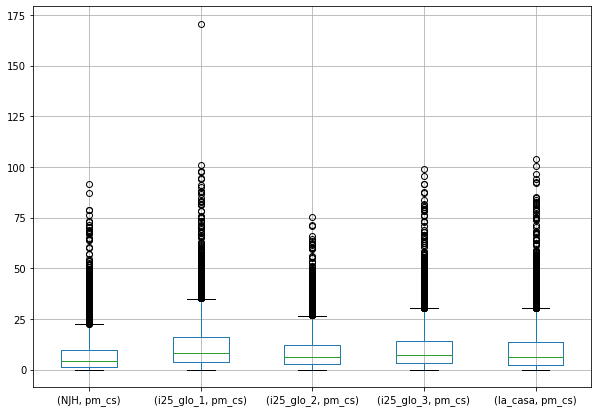

<IPython.core.display.Javascript object>

In [20]:
training_data[["cs_sensor", "pm_cs"]].groupby("cs_sensor")[["pm_cs"]].boxplot(
    subplots=False, figsize=(10, 7)
)
plt.show()

###### Test

In [21]:
test_data.groupby("cs_sensor")[["pm_cs"]].describe()

pm_cs                                                         \
             count       mean        std     min     25%     50%      75%   
cs_sensor                                                                   
CAMP         737.0   5.534936   4.877164  0.0027  2.0993  4.0932   7.2847   
i25_denver  2269.0  11.194916  11.575899  0.0033  3.4947  7.2713  14.1788   

                     
                max  
cs_sensor            
CAMP        30.9088  
i25_denver  68.9408

<IPython.core.display.Javascript object>

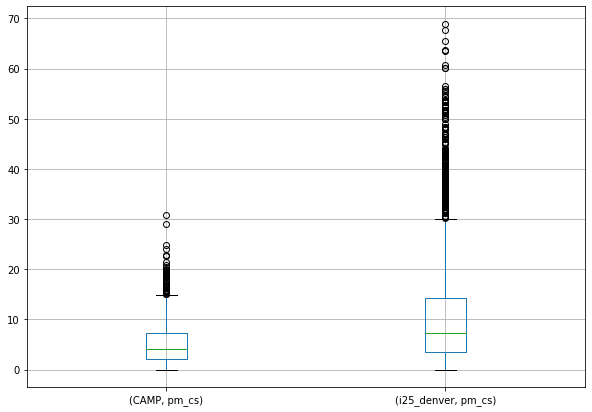

<IPython.core.display.Javascript object>

In [22]:
test_data[["cs_sensor", "pm_cs"]].groupby("cs_sensor")[["pm_cs"]].boxplot(
    subplots=False, figsize=(10, 7)
)
plt.show()

- Take note of the IQR for CAMP and NJH. The IQR in these locations are lower than in the other locations. CAMP and NJH are farther away from the express way (see map).

# 4.  Scatterplot comparing AirNow and CS PM2.5 

A scatterplot shows the relationship between two quantitative variables measure in the same unit/space

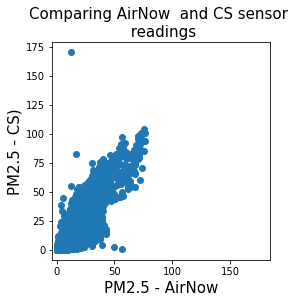

<IPython.core.display.Javascript object>

In [23]:
plt.scatter(full_data["pm_airnow"], full_data["pm_cs"])
plt.ylabel("PM2.5 - CS)", size=15)
plt.xlabel("PM2.5 - AirNow", size=15)
plt.title("Comparing AirNow  and CS sensor \n readings", size=15)
plt.axis("square")
plt.show()

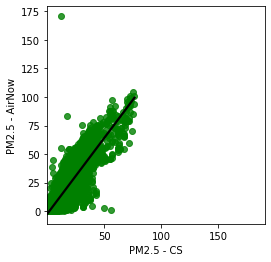

<IPython.core.display.Javascript object>

In [24]:
ax = sns.regplot(
    x=full_data["pm_airnow"],
    y=full_data["pm_cs"],
    color="green",
    line_kws={"color": "black"},
)

ax.set(xlabel="PM2.5 - CS", ylabel="PM2.5 - AirNow")
plt.axis("square")
plt.show()

**What can we do with this plot?** <br>
We can understand the relationship between our "true" PM2.5 values and the ones mesaured from our low-cost sensors


- The need for correction. A linear model is useful for this.
- A linear model could find the line of best fit here. We might not even need data other confounding variables to have a good starting model.

We can split our data by CS sensors to observe if there are any significant changes with respect to what has been observed over the whole data.

In [25]:
njh_data = full_data[full_data["cs_sensor"] == "NJH"]
i25_glo1_data = full_data[full_data["cs_sensor"] == "i25_glo_1"]
i25_glo2_data = full_data[full_data["cs_sensor"] == "i25_glo_2"]
i25_glo3_data = full_data[full_data["cs_sensor"] == "i25_glo_3"]
lacasa_data = full_data[full_data["cs_sensor"] == "la_casa"]
camp_data = full_data[full_data["cs_sensor"] == "CAMP"]
i25_denver_data = full_data[full_data["cs_sensor"] == "i25_denver"]

<IPython.core.display.Javascript object>

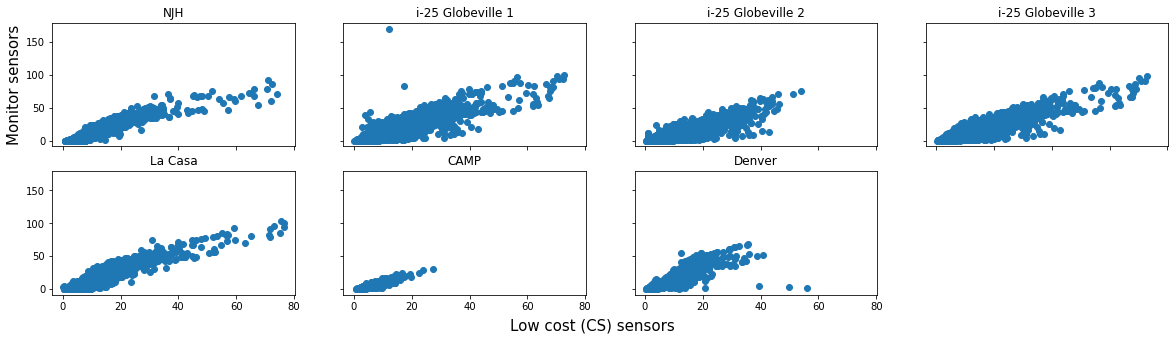

<IPython.core.display.Javascript object>

In [26]:
fig, [(ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8)] = plt.subplots(
    nrows=2, ncols=4, figsize=(20, 5), sharex=True, sharey=True
)

ax1.scatter(njh_data["pm_airnow"], njh_data["pm_cs"])
ax1.set_title("NJH")

ax2.scatter(i25_glo1_data["pm_airnow"], i25_glo1_data["pm_cs"])
ax2.set_title("i-25 Globeville 1")
ax3.scatter(i25_glo2_data["pm_airnow"], i25_glo2_data["pm_cs"])
ax3.set_title("i-25 Globeville 2")
ax4.scatter(i25_glo3_data["pm_airnow"], i25_glo3_data["pm_cs"])
ax4.set_title("i-25 Globeville 3")
ax5.scatter(lacasa_data["pm_airnow"], lacasa_data["pm_cs"])
ax5.set_title("La Casa")
ax6.scatter(camp_data["pm_airnow"], camp_data["pm_cs"])
ax6.set_title("CAMP")

ax7.scatter(i25_denver_data["pm_airnow"], i25_denver_data["pm_cs"])
ax7.set_title("Denver")

ax8.axis("off")

ax1.set_ylabel("Monitor sensors", size=15)
fig.text(0.5, 0.04, "Low cost (CS) sensors", ha="center", va="center", size=15)

plt.show()

What do we observe? Any differences across the different CS sensors

- Some potential outlier measures at I-25 Globeville 1

# 4.  Historgrams comparing AirNow and CS PM2.5 

What histograms can tell us about the ditribution of our data:

- Is it unimodal, bimodal, or multimodal?
- how widely is the distribution spread?
- Do the distributions overlap for the different sensors?

###### Choosing bin size.

One simple rule is [Sturge’s rule](https://www.researchgate.net/publication/230257056_Sturges'_rule)

$K = 1 + 3.22 log(N)$

where,

K is the number of bins

N is the number of observations

In [27]:
def bin_size(n_observations):

    return math.ceil(1 + (3.22 * math.log(n_observations)))

<IPython.core.display.Javascript object>

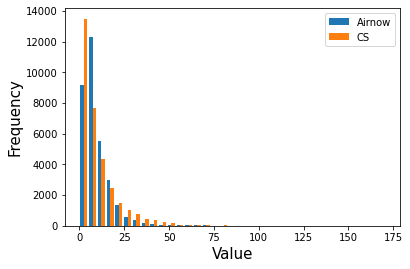

<IPython.core.display.Javascript object>

In [28]:
plt.hist(
    [full_data["pm_airnow"], full_data["pm_cs"]],
    bins=bin_size(len(full_data)),
)
plt.xlabel("Value", size=15)
plt.ylabel("Frequency", size=15)
plt.legend()
plt.show()

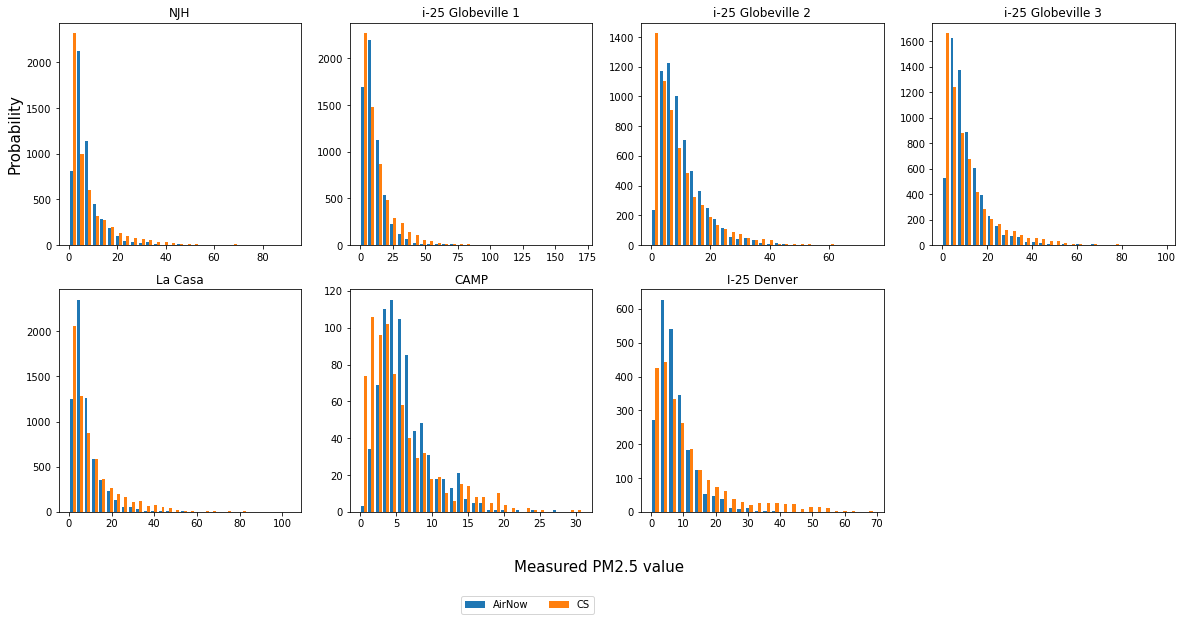

<IPython.core.display.Javascript object>

In [59]:
labels = ["AirNow", "CS"]
fig, [(ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8)] = plt.subplots(
    nrows=2, ncols=4, figsize=(20, 9)
)  # , sharex=True, sharey=True)

ax1.hist(
    [njh_data["pm_airnow"], njh_data["pm_cs"]],
    bins=bin_size(len(njh_data)),
)
ax1.set_title("NJH")


ax2.hist(
    [i25_glo1_data["pm_airnow"], i25_glo1_data["pm_cs"]],
    bins=bin_size(len(i25_glo1_data)),
)
ax2.set_title("i-25 Globeville 1")

ax3.hist(
    [i25_glo2_data["pm_airnow"], i25_glo2_data["pm_cs"]],
    bins=bin_size(len(i25_glo2_data)),
)
ax3.set_title("i-25 Globeville 2")

ax4.hist(
    [i25_glo3_data["pm_airnow"], i25_glo3_data["pm_cs"]],
    bins=bin_size(len(i25_glo3_data)),
)
ax4.set_title("i-25 Globeville 3")

ax5.hist(
    [lacasa_data["pm_airnow"], lacasa_data["pm_cs"]],
    bins=bin_size(len(lacasa_data)),
)
ax5.set_title("La Casa")


ax6.hist(
    [camp_data["pm_airnow"], camp_data["pm_cs"]],
    bins=bin_size(len(lacasa_data)),
)
ax6.set_title("CAMP")

ax7.hist(
    [i25_denver_data["pm_airnow"], i25_denver_data["pm_cs"]],
    bins=bin_size(len(i25_denver_data)),
)
ax7.set_title("I-25 Denver")

ax8.axis("off")

ax1.set_ylabel("Probability", size=15)
fig.text(0.5, 0.04, "Measured PM2.5 value", ha="center", va="center", size=15)
fig.legend(
    labels,
    loc="lower right",
    bbox_to_anchor=(0.5, -0.04),
    ncol=len(labels),
    bbox_transform=fig.transFigure,
)
plt.show()

# What happens on weekends?

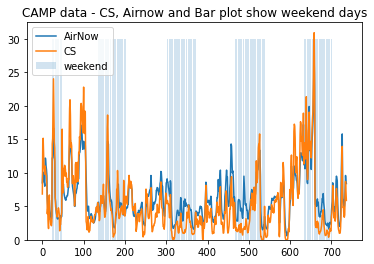

<IPython.core.display.Javascript object>

In [60]:
plt.plot(camp_data["pm_airnow"], label="AirNow")
plt.plot(camp_data["pm_cs"], label="CS")
plt.bar(
    x=range(0, len(camp_data)),
    height=[x * 30 for x in camp_data["weekend"]],
    alpha=0.2,
    label="weekend",
)

plt.title("CAMP data - CS, Airnow and Bar plot show weekend days")
plt.legend()
plt.show()

In [61]:
weekend_median = full_data[full_data["weekend"] == 1]["pm_airnow"].median()
weekday_median = full_data[full_data["weekend"] != 1]["pm_airnow"].median()

<IPython.core.display.Javascript object>

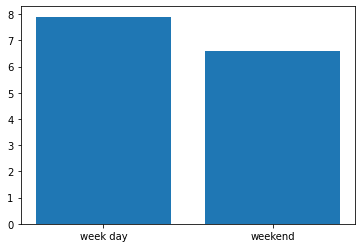

<IPython.core.display.Javascript object>

In [62]:
plt.bar(x=["week day", "weekend"], height=[weekday_median, weekend_median])
plt.show()

There is lower PM2.5 on weekends than on weekdays. This could be due to reduction in industrial activities, traffic on highways and other sources of pollution over the weekend

In [63]:
corr = full_data[["pm_airnow", "pm_cs", "temp", "humidity"]].corr()
corr.style.background_gradient(cmap="coolwarm")

,pm_airnow,pm_cs,temp,humidity
pm_airnow,1.000000,0.893759,-0.163799,0.226491
pm_cs,0.893759,1.000000,-0.213838,0.314056
temp,-0.163799,-0.213838,1.000000,-0.687621
humidity,0.226491,0.314056,-0.687621,1.000000


<IPython.core.display.Javascript object>

`pm_cs` and `pm_airnow` show high linear correlation of 0.89. 

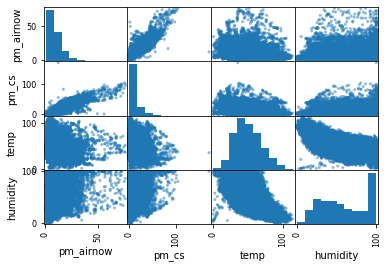

<IPython.core.display.Javascript object>

In [64]:
pd.plotting.scatter_matrix(full_data[["pm_airnow", "pm_cs", "temp", "humidity"]])
plt.show()

`pm_cs` and `pm_airnow` show high linear correlation. 